In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from fbprophet import Prophet

In [4]:
data = pd.read_csv('data_clean.csv')
data.head()

,Unnamed: 0,orderID,SKU,itemName,category,salesNum,dealPrice,customerID,date,region,province,city,storeID,store
0,99233,222160,105437,【买赠】博乐丹宠物洁牙粉（犬猫通用）40g,生活日用,2,338.0,217839,2020-06-01,华东区,安徽省,合肥市,926,宠颐生·合肥区大润发分院
1,99234,222160,1000122001,博乐丹宠物洁牙粉尝鲜装（犬猫通用）5g 5g,生活日用,4,0.0,217839,2020-06-01,华东区,安徽省,合肥市,926,宠颐生·合肥区大润发分院
2,99235,222186,105088,麦德氏IN-Plus犬育儿宝A+狗狗营养品发育整肠泰迪金毛调理肠胃益生菌 250g,营养保健,1,128.0,610518,2020-06-01,华东区,江苏省,常州市,839,安安宠医·常州旺财分院
3,99236,222218,105698,【买赠】贵族益能系列全价小型犬粮（全期）1.5kg 1.5kg,狗狗主粮,1,66.0,736665,2020-06-01,华东区,江苏省,无锡市,852,安安宠医·无锡佳康分院
4,99237,222218,105570,【买赠】伯纳天纯 味臻纯食材探索小型犬挑嘴犬粮2kg 小型犬挑嘴犬粮2kg,狗狗主粮,1,82.0,736665,2020-06-01,华东区,江苏省,无锡市,852,安安宠医·无锡佳康分院


In [5]:
# create a new dataframe with index of date
df = pd.DataFrame({'date':sorted(list(set(data.date))),'tot_sale':data.groupby(['date']).sum()['salesNum'].tolist()})
df.set_index('date',inplace=True)
df.head()

,tot_sale
date,
2020-06-01,233
2020-06-02,106
2020-06-03,276
2020-06-04,139
2020-06-05,178


In [6]:
for category in data.category.unique():
    tmp_sales = data[data['category']==category].groupby(['date']).sum()['salesNum']
    tmp_df = pd.DataFrame({'date':tmp_sales.index, '{}sales'.format(category):tmp_sales.values})
    tmp_df.set_index('date',inplace=True)
    df=df.join(tmp_df)

df_price= pd.DataFrame({'date':sorted(list(set(data.date))),'tot_price':data.groupby(['date']).sum()['dealPrice'].tolist()})
df_price.set_index('date',inplace=True)
df = df.join(df_price)
df.head()

,tot_sale,生活日用sales,营养保健sales,狗狗主粮sales,狗狗玩具sales,狗狗零食sales,医疗护理sales,狗狗美容sales,出行装备sales,猫咪主粮sales,猫咪零食sales,猫砂猫厕sales,猫咪玩具sales,猫咪美容sales,实物商品sales,tot_price
date,,,,,,,,,,,,,,,,
2020-06-01,233,28.0,30,15.0,3.0,11.0,1.0,NaN,NaN,22.0,116.0,2.0,5.0,NaN,NaN,8664.20
2020-06-02,106,9.0,14,16.0,4.0,24.0,NaN,NaN,NaN,19.0,16.0,NaN,4.0,NaN,NaN,4155.80
2020-06-03,276,15.0,25,9.0,3.0,106.0,3.0,NaN,NaN,8.0,103.0,1.0,3.0,NaN,NaN,6079.10
2020-06-04,139,8.0,12,24.0,7.0,24.0,2.0,4.0,NaN,15.0,37.0,3.0,3.0,NaN,NaN,5858.20
2020-06-05,178,3.0,9,13.0,2.0,66.0,1.0,2.0,NaN,4.0,68.0,9.0,1.0,NaN,NaN,4539.68


In [7]:
print('In total there are {} days'.format(len(df.index)))
col_to_drop = []
for i in df.columns:
    print('{} column has {} missing values'.format(i,df[i].isna().sum()))
    if df[i].isna().sum() > 50:
        col_to_drop.append(i)
print(col_to_drop)

In total there are 103 days
tot_sale column has 0 missing values
生活日用sales column has 26 missing values
营养保健sales column has 0 missing values
狗狗主粮sales column has 1 missing values
狗狗玩具sales column has 74 missing values
狗狗零食sales column has 6 missing values
医疗护理sales column has 12 missing values
狗狗美容sales column has 60 missing values
出行装备sales column has 101 missing values
猫咪主粮sales column has 4 missing values
猫咪零食sales column has 5 missing values
猫砂猫厕sales column has 16 missing values
猫咪玩具sales column has 63 missing values
猫咪美容sales column has 91 missing values
实物商品sales column has 97 missing values
tot_price column has 0 missing values
['狗狗玩具sales', '狗狗美容sales', '出行装备sales', '猫咪玩具sales', '猫咪美容sales', '实物商品sales']


In [8]:
for col in col_to_drop:
    df = df.drop([col], axis = 1)

df=df.fillna(0)
df.head()

,tot_sale,生活日用sales,营养保健sales,狗狗主粮sales,狗狗零食sales,医疗护理sales,猫咪主粮sales,猫咪零食sales,猫砂猫厕sales,tot_price
date,,,,,,,,,,
2020-06-01,233,28.0,30,15.0,11.0,1.0,22.0,116.0,2.0,8664.20
2020-06-02,106,9.0,14,16.0,24.0,0.0,19.0,16.0,0.0,4155.80
2020-06-03,276,15.0,25,9.0,106.0,3.0,8.0,103.0,1.0,6079.10
2020-06-04,139,8.0,12,24.0,24.0,2.0,15.0,37.0,3.0,5858.20
2020-06-05,178,3.0,9,13.0,66.0,1.0,4.0,68.0,9.0,4539.68


In [13]:
fig = px.scatter(df, x=df.index, y=['tot_sale','tot_price'])
fig.show()

In [14]:
quant = data.groupby(['date']).sum()['salesNum'].tolist()
fig1 = px.scatter(x=sorted(list(set(data.date))), y=quant)
fig1.show()

In [15]:
simp_data = pd.DataFrame({'date':sorted(list(set(data.date))),'sales':quant})
simp_data.columns = ['ds','y']
# replace extreme value with second largest value
simp_data.loc[17,'y']=468
fig2 = px.scatter(x=sorted(list(set(data.date))), y=simp_data['y'])
fig2.show()

In [16]:
from sklearn.metrics import mean_absolute_error
def evaluate(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    MAPE = np.mean(diff / true)
    return MAPE,mean_absolute_error(true,pred)


# PROPHET

In [6]:
model_p = Prophet()
model_p.fit(simp_data)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
hist = sorted(list(set(data.date)))[-103:]
hist = pd.DataFrame(hist)
hist.columns = ['ds']


fit Prophet model

          ds        yhat  yhat_lower  yhat_upper
0 2020-06-01  198.635896   62.031899  317.946018
1 2020-06-02  167.838353   48.960041  293.553406
2 2020-06-03  225.477965   96.359627  343.201967
3 2020-06-04  234.015413  106.683962  355.002930
4 2020-06-05  191.598859   68.058129  312.839374


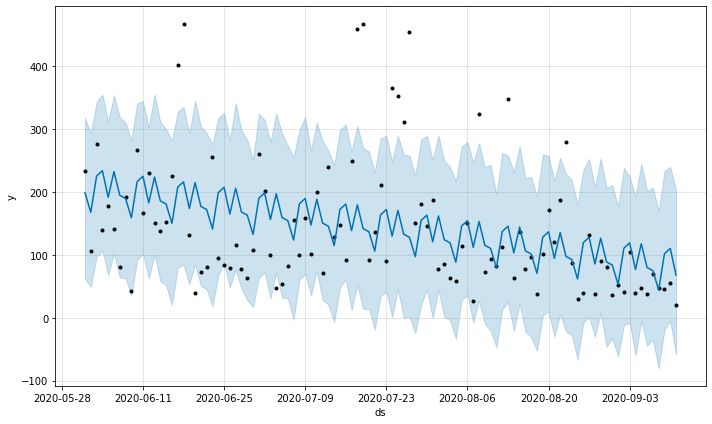

In [8]:
forecast_hist = model_p.predict(hist)
print(forecast_hist[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model_p.plot(forecast_hist)
plt.show()

generate forecast

In [ ]:
# create future dates for prediction
future = list()
for i in range(12, 19):
	date = '2020-09-{}'.format(i)
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast_future = model_p.predict(future)
print(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model_p.plot(forecast_future)
plt.show()

# ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from random import random
# fit model
model_arima = ARIMA(simp_data.y, order=(1, 1, 1))
model_arima_fit = model_arima.fit(disp=False)
# get smoothed data with prediction
yhat_arima = model_arima_fit.predict(start=1,end=103,typ='levels')
# plot prediction with existing data
plt.figure(figsize=(10,7))
plt.plot(list(range(103)),yhat,label='ARIMA prediction')
plt.plot(list(range(len(simp_data.y))),simp_data.y,label='Data observed')
plt.legend()
plt.show()

In [ ]:
MAPE(simp_data['y'],yhat_arima)

# HWES

In [21]:
len(yhat_hwes)

7

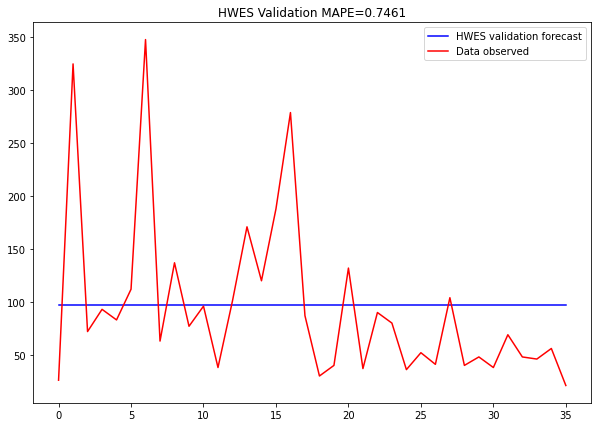

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
split_time=int(np.round(len(simp_data.y)*0.66))
model_hwes = ExponentialSmoothing(simp_data.y[:split_time],dates=simp_data['ds'],freq='D')
model_hwes_fit = model_hwes.fit()
# make prediction
yhat_hwes = model_hwes_fit.predict(start=split_time,end=103)
plt.figure(figsize=(10,7))
plt.plot(list(range(104-split_time)),yhat_hwes,label='HWES validation forecast',color='b')
plt.plot(list(range(104-split_time)),simp_data.y[split_time-1:],label='Data observed',color='r')
plt.title('HWES Validation MAPE={:0.4f}'.format(MAPE(simp_data['y'][-len(yhat_hwes)-1:-1],yhat_hwes)))
plt.legend()
plt.show()

# DNN

In [126]:
import tensorflow as tf

Prepare data for training and validation using sliding window method

In [48]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

    
split_time = int(np.round(len(simp_data.y)*0.66))

x_train = np.array(simp_data.y)[:split_time]
time_train = np.array(simp_data.ds[:split_time])
x_valid = np.array(simp_data.y)[split_time:]
time_valid = np.array(simp_data.ds[split_time:])

window_size = 7
batch_size = 32
shuffle_buffer_size = 100

In [49]:
train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [50]:

model_dnn=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
model_dnn.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=5e-6))
model_dnn.fit(train_data, epochs=200, verbose=1)

Epoch 1/200
2/2 [==============================] - 3s 2s/step - loss: 49661.5234
Epoch 2/200
2/2 [==============================] - 0s 56ms/step - loss: 20918.0741
Epoch 3/200
2/2 [==============================] - 0s 43ms/step - loss: 19487.1969
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 16154.9174
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 15685.1752
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 16969.1759
Epoch 7/200
2/2 [==============================] - 0s 31ms/step - loss: 10937.0762
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 11298.6250
Epoch 9/200
2/2 [==============================] - 0s 30ms/step - loss: 13165.8259
Epoch 10/200
2/2 [==============================] - 0s 27ms/step - loss: 11945.8849
Epoch 11/200
2/2 [==============================] - 0s 25ms/step - loss: 11170.2062
Epoch 12/200
2/2 [==============================] - 0s 26ms/step - loss: 13499.1189
Epo

In [55]:
tf.keras.models.save_model(model_dnn,'model_dnn.h5',save_format='h5')

In [12]:
forecast = []
for time in range(len(np.array(simp_data.y)) - window_size):
  forecast.append(model_dnn.predict(np.array(simp_data.y)[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

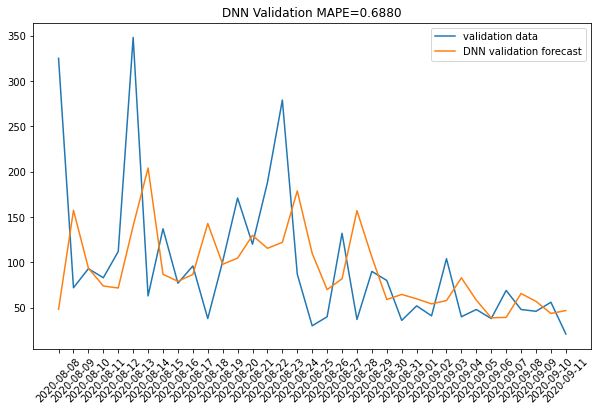

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid,label='Validation Data')
plt.plot(time_valid, results,label='DNN validation forecast')
plt.title('DNN Validation MAPE={:0.4f}'.format(MAPE(x_valid,results)))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Conv+LSTM

In [12]:
def windowed_dataset_lstm(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
dataset = windowed_dataset_lstm(x_train, window_size, batch_size, shuffle_buffer_size)

In [45]:
for x,y in dataset:
    print(x.shape, y.shape)
    print(x.numpy())
    print('-----------------------')
    print(y.numpy())

(32, 7, 1) (32, 7, 1)
[[[ 95]
  [ 84]
  [ 79]
  [116]
  [ 77]
  [ 64]
  [108]]

 [[136]
  [211]
  [ 90]
  [366]
  [353]
  [311]
  [455]]

 [[141]
  [ 81]
  [192]
  [ 43]
  [267]
  [167]
  [231]]

 [[188]
  [ 77]
  [ 86]
  [ 64]
  [ 58]
  [114]
  [151]]

 [[100]
  [ 47]
  [ 53]
  [ 83]
  [155]
  [100]
  [158]]

 [[ 39]
  [ 72]
  [ 80]
  [255]
  [ 95]
  [ 84]
  [ 79]]

 [[ 64]
  [108]
  [261]
  [201]
  [100]
  [ 47]
  [ 53]]

 [[ 72]
  [ 80]
  [255]
  [ 95]
  [ 84]
  [ 79]
  [116]]

 [[459]
  [468]
  [ 92]
  [136]
  [211]
  [ 90]
  [366]]

 [[276]
  [139]
  [178]
  [141]
  [ 81]
  [192]
  [ 43]]

 [[151]
  [181]
  [146]
  [188]
  [ 77]
  [ 86]
  [ 64]]

 [[150]
  [138]
  [152]
  [226]
  [402]
  [468]
  [131]]

 [[116]
  [ 77]
  [ 64]
  [108]
  [261]
  [201]
  [100]]

 [[102]
  [200]
  [ 71]
  [240]
  [128]
  [147]
  [ 92]]

 [[353]
  [311]
  [455]
  [151]
  [181]
  [146]
  [188]]

 [[131]
  [ 39]
  [ 72]
  [ 80]
  [255]
  [ 95]
  [ 84]]

 [[ 90]
  [366]
  [353]
  [311]
  [455]
  [151]
  

In [14]:
conv_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
conv_lstm.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = conv_lstm.fit(dataset,epochs=300)

81.4256 - mae: 80.4632
Epoch 95/300
2/2 [==============================] - 0s 32ms/step - loss: 79.5334 - mae: 80.4353
Epoch 96/300
2/2 [==============================] - 0s 28ms/step - loss: 76.6930 - mae: 80.3853
Epoch 97/300
2/2 [==============================] - 0s 31ms/step - loss: 78.2663 - mae: 80.3548
Epoch 98/300
2/2 [==============================] - 0s 28ms/step - loss: 75.8818 - mae: 80.3171
Epoch 99/300
2/2 [==============================] - 0s 29ms/step - loss: 81.6784 - mae: 80.2863
Epoch 100/300
2/2 [==============================] - 0s 34ms/step - loss: 76.9523 - mae: 80.2477
Epoch 101/300
2/2 [==============================] - 0s 49ms/step - loss: 81.7181 - mae: 80.2209
Epoch 102/300
2/2 [==============================] - 0s 39ms/step - loss: 78.2814 - mae: 80.1900
Epoch 103/300
2/2 [==============================] - 0s 29ms/step - loss: 77.1205 - mae: 80.1489
Epoch 104/300
2/2 [==============================] - 0s 31ms/step - loss: 80.3435 - mae: 80.1266
Epoch 105/30

In [56]:
tf.keras.models.save_model(conv_lstm,'model_LSTM.h5',save_format='h5')

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
series = np.array(simp_data.y)
series = series.astype(float)
type(series[0])

numpy.float64

In [17]:
rnn_forecast = model_forecast(conv_lstm, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

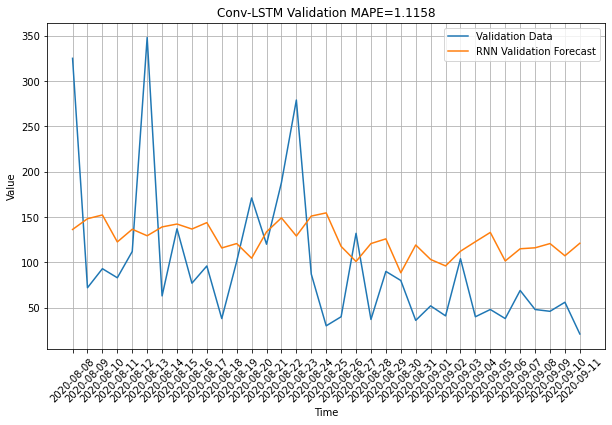

In [24]:
def plot_series(time, series, format="-", start=0, end=None,label=None):
    plt.plot(time[start:end], series[start:end], format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,label='Validation Data')
plot_series(time_valid, rnn_forecast,label='RNN Validation Forecast')
plt.title('Conv-LSTM Validation MAPE={:0.4f}'.format(MAPE(x_valid,rnn_forecast)))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Random Forest

In [100]:
from sklearn.model_selection import GridSearchCV

In [17]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
# choose a number of time steps
n_steps = 7
n_features = 1
# split into samples
X, y = split_sequence(simp_data['y'], n_steps)

In [101]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [110]:
gbrt = GradientBoostingRegressor(random_state=42)
params = dict(n_estimators=list(range(1,30)),learning_rate=np.linspace(0,1,11)[2:11])
reg = GridSearchCV(gbrt, params)
search = reg.fit(X_train, y_train)
search.best_params_
# min_val_err = float('inf')
# err_going_up = 0
# for n_estimators in range(1,20):
#     gbrt.n_estimators=n_estimators
#     gbrt.fit(X_train, y_train)
#     pred_gbr = gbrt.predict(X_val)
#     val_err = mean_absolute_error(y_val,pred_gbr)
#     if val_err < min_val_err:
#         min_val_err=val_err
#         err_going_up=0
#     else:
#         err_going_up += 1
#         if err_going_up ==5:
#             break
# print(n_estimators)

{'learning_rate': 0.2, 'n_estimators': 3}

In [114]:
gbrt = GradientBoostingRegressor(random_state=42, n_estimators=3,learning_rate=0.2)
gbrt.fit(X_train,y_train)
pred_gbr = gbrt.predict(X_val)
evaluate(y_val,pred_gbr)

(1.0551907190220815, 70.1941355988456)

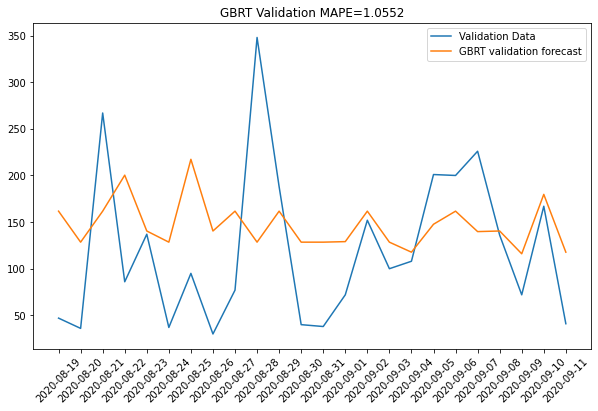

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(list(df.index[-24:]), y_val,label='Validation Data')
plt.plot(list(df.index[-24:]), pred_gbr,label='GBRT validation forecast')
plt.title('GBRT Validation MAPE={:0.4f}'.format(evaluate(y_val,pred_gbr)[0]))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# SVR

In [21]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train,y_train)
pred_svr = svr.predict(X_val)
evaluate(y_val,pred_svr)

(0.754500447809861, 65.20833333333333)

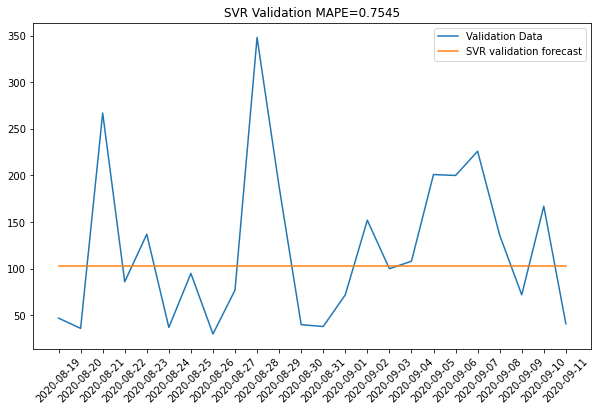

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(list(df.index[-24:]), y_val,label='Validation Data')
plt.plot(list(df.index[-24:]), pred_svr,label='SVR validation forecast')
plt.title('SVR Validation MAPE={:0.4f}'.format(evaluate(y_val,pred_svr)[0]))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostRegressor

In [118]:
ada = AdaBoostRegressor(random_state=42)
params = dict(n_estimators=list(range(1,30)),learning_rate=np.linspace(0,1,11)[2:11])
reg = GridSearchCV(ada, params)
search = reg.fit(X_train, y_train)
search.best_params_

{'learning_rate': 0.4, 'n_estimators': 5}

In [120]:
ada = AdaBoostRegressor(random_state=42,learning_rate=0.4,n_estimators=5)
ada.fit(X_train,y_train)
pred_ada = ada.predict(X_val)
evaluate(y_val,pred_ada)

(0.9544293961180722, 69.35597388832683)

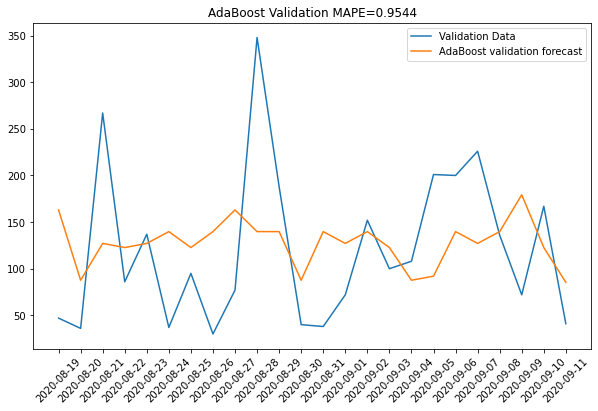

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(list(df.index[-24:]), y_val,label='Validation Data')
plt.plot(list(df.index[-24:]), pred_ada,label='AdaBoost validation forecast')
plt.title('AdaBoost Validation MAPE={:0.4f}'.format(evaluate(y_val,pred_ada)[0]))
plt.xticks(rotation=45)
plt.legend()
plt.show()